In [45]:
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from Evaluation.Evaluator import EvaluatorHoldout
from Data_Handler.DataReader import DataReader
import scipy.sparse as sps
from collections import Counter
from tqdm import tqdm
# imports for .env usage
import os
from dotenv import load_dotenv
load_dotenv()



True

In [33]:
dataReader = DataReader()
URM = dataReader.load_augmented_binary_urm()
URM_aug,icm = dataReader.pad_with_zeros_ICMandURM(URM)

URM_train_aug, URM_validation = split_train_in_two_percentage_global_sample(URM_aug, train_percentage = 0.9)
URM_train_pow = dataReader.stackMatrixes(URM_train_aug)

4877


In [34]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train_aug).indptr)
profile_length, profile_length.shape

(array([58, 20, 94, ..., 22, 48, 19], dtype=int32), (41629,))

In [35]:
block_size = int(len(profile_length)*0.05)
block_size

2081

In [36]:
sorted_users = np.argsort(profile_length)
sorted_users

array([21852, 25061, 38400, ..., 19407, 12454,  8693], dtype=int64)

In [37]:
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 11.43, median 12.0, min 3, max 13
Group 1, #users in group 2081, average p.len 14.30, median 14.0, min 13, max 15
Group 2, #users in group 2081, average p.len 15.95, median 16.0, min 15, max 17
Group 3, #users in group 2081, average p.len 17.37, median 17.0, min 17, max 18
Group 4, #users in group 2081, average p.len 18.56, median 19.0, min 18, max 19
Group 5, #users in group 2081, average p.len 19.71, median 20.0, min 19, max 20
Group 6, #users in group 2081, average p.len 20.96, median 21.0, min 20, max 22
Group 7, #users in group 2081, average p.len 22.28, median 22.0, min 22, max 23
Group 8, #users in group 2081, average p.len 23.54, median 24.0, min 23, max 24
Group 9, #users in group 2081, average p.len 24.98, median 25.0, min 24, max 26


In [38]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMItemHybridRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {
        #"SLIMElasticNetRecommender": SLIMElasticNetRecommender,
        "UserKNNCF": UserKNNCFRecommender,
        "ItemKNNCF": ItemKNNCFRecommender,
        "RP3beta": RP3betaRecommender,
        #"TopPop": TopPop,
}

recommender_object_dict = {}
recommended_items_for_each_user = {}

for label, recommender_class in collaborative_recommender_class.items():
    if(label == "SLIMElasticNetRecommender" or label== 'RP3beta'):
        recommender_object = recommender_class(URM_train_pow)
        recommender_object.fit()
    else:
        recommender_object = recommender_class(URM_train_aug)
        recommender_object.fit()
    recommender_object_dict[label] = recommender_object


UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Similarity column 41629 (100.0%), 1358.52 column/sec. Elapsed time 30.64 sec
ItemKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Similarity column 27968 (100.0%), 4160.34 column/sec. Elapsed time 6.72 sec
RP3betaRecommender: Similarity column 27968 (100.0%), 911.49 column/sec. Elapsed time 30.68 sec


In [39]:
evaluator=EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2865 ( 6.9%) Users that have less than 1 test interactions


In [40]:
URM_validation.shape

(41629, 27968)

In [41]:
URM_train_aug.shape

(41629, 27968)

In [42]:
URM_train_pow

<41634x27968 sparse matrix of type '<class 'numpy.float64'>'
	with 1422265 stored elements in Compressed Sparse Row format>

In [43]:
from evaluator import evaluate
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_power = EvaluatorHoldout(URM_validation_aug, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_pad = EvaluatorHoldout(val_pad, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        #if(label == "SLIMElasticNetRecommender"):
            #map=evaluate(recommended_items_for_each_user,val_powerful,target)
        #    result_df, _ = evaluator_power.evaluateRecommender(recommender)

        #elif label == "LightFMItemHybridRecommender":
            #result_df, _ = evaluator_pad.evaluateRecommender(recommender)
        
        #else:
            #map=evaluate(recommended_items_for_each_user,URM_validation,target)
            #result_df, _ = evaluator_test.evaluateRecommender(recommender)
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            #MAP_recommender_per_group[label].append(map)
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
            #MAP_recommender_per_group[label] = [map]


Group 0, #users in group 2081, average p.len 11.43, median 12.0, min 3, max 13
EvaluatorHoldout: Ignoring 2865 ( 6.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1791 (100.0%) in 3.36 sec. Users per second: 533
EvaluatorHoldout: Processed 1791 (100.0%) in 3.50 sec. Users per second: 512
EvaluatorHoldout: Processed 1791 (100.0%) in 3.00 sec. Users per second: 596
Group 1, #users in group 2081, average p.len 14.30, median 14.0, min 13, max 15
EvaluatorHoldout: Ignoring 2865 ( 6.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1807 (100.0%) in 3.48 sec. Users per second: 519
EvaluatorHoldout: Processed 1807 (100.0%) in 3.43 sec. Users per second: 527
EvaluatorHoldout: Processed 1807 (100.0%) in 2.69 sec. Users per second: 673
Group 2, #users in group 2081, average p.len 15.95, median 16.0, min 15, max 17
EvaluatorHoldout: Ignoring 2865 ( 6.9%) Users tha

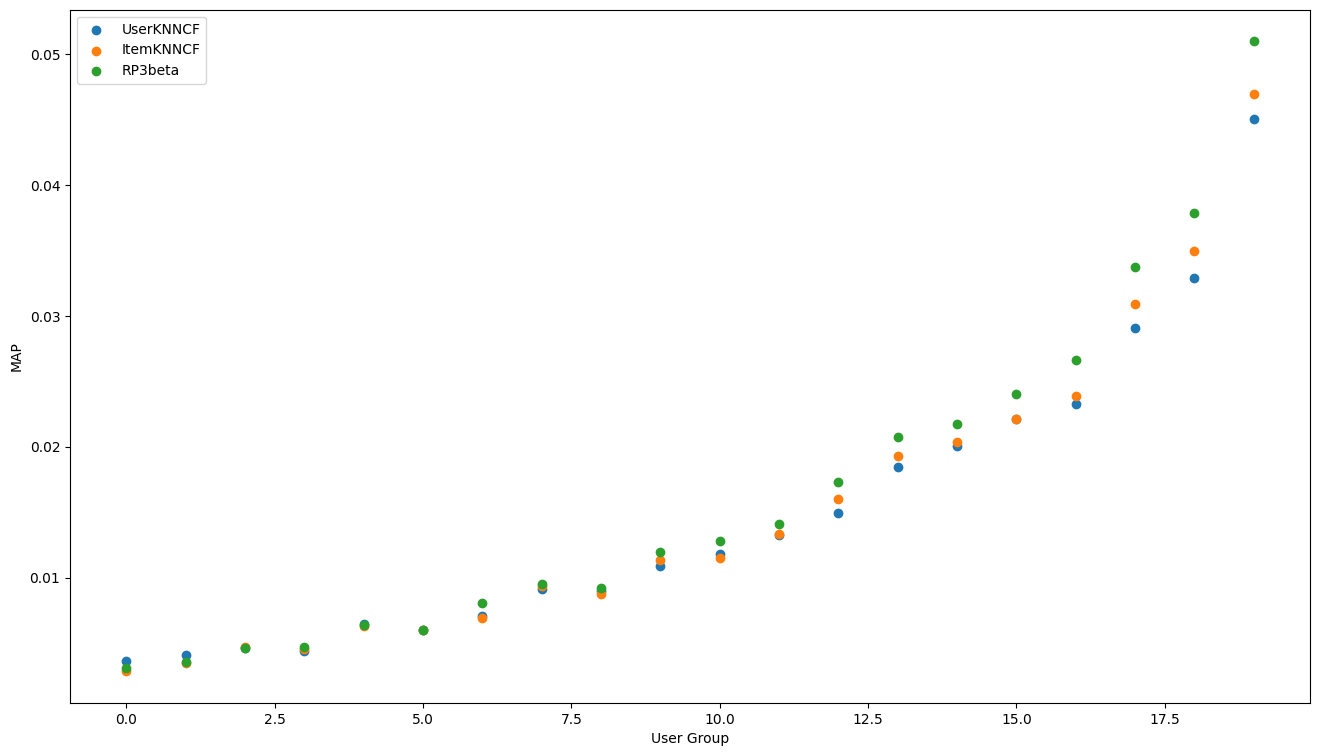

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()